# Dataset
https://www.kaggle.com/code/robikscube/daily-exchange-rates-dataset

In [1]:
import pandas as pd
from itertools import cycle
import matplotlib.pylab as plt
import seaborn as sns
import os
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

plt.style.use("seaborn-whitegrid")
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
bitcoin_df = pd.read_csv('input\coin_Bitcoin.csv')
bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'], infer_datetime_format=True)
bitcoin_df.columns
bitcoin_df

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11


In [3]:
bitcoin_df = bitcoin_df.set_index('Date')

# Resampling to monthly frequency
df_month = bitcoin_df.resample('M').mean(numeric_only=True)
# Resampling to annual frequency
df_year = bitcoin_df.resample('A-DEC').mean(numeric_only=True)

# Resampling to quarterly frequency
df_Q = bitcoin_df.resample('Q-DEC').mean(numeric_only=True)

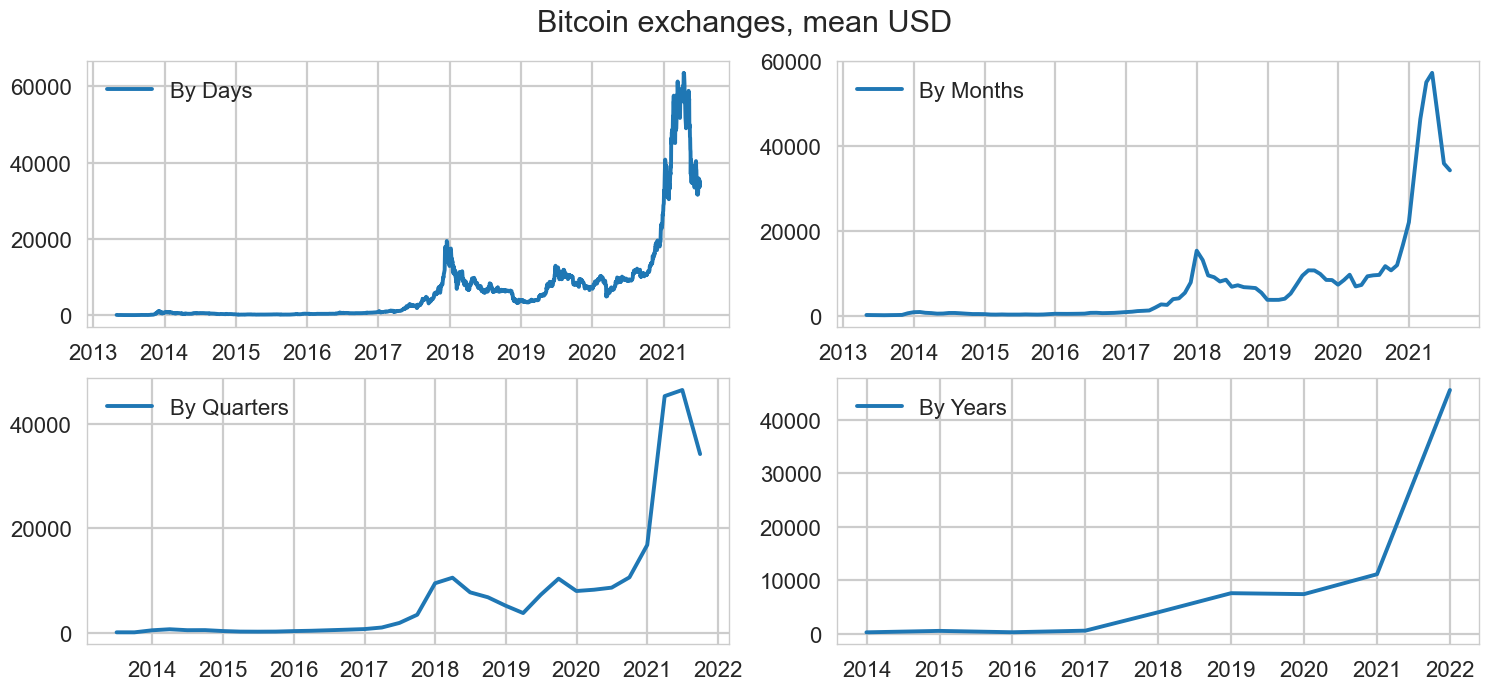

In [4]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(bitcoin_df['Close'], '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month['Close'], '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q['Close'], '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year['Close'], '-', label='By Years')
plt.legend()

plt.tight_layout()
plt.show()

Dickey–Fuller test: p=(2.4399227467349127, 0.9990278760819885, 4, 95, {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}, 1585.1051941427859)


<Figure size 1500x700 with 0 Axes>

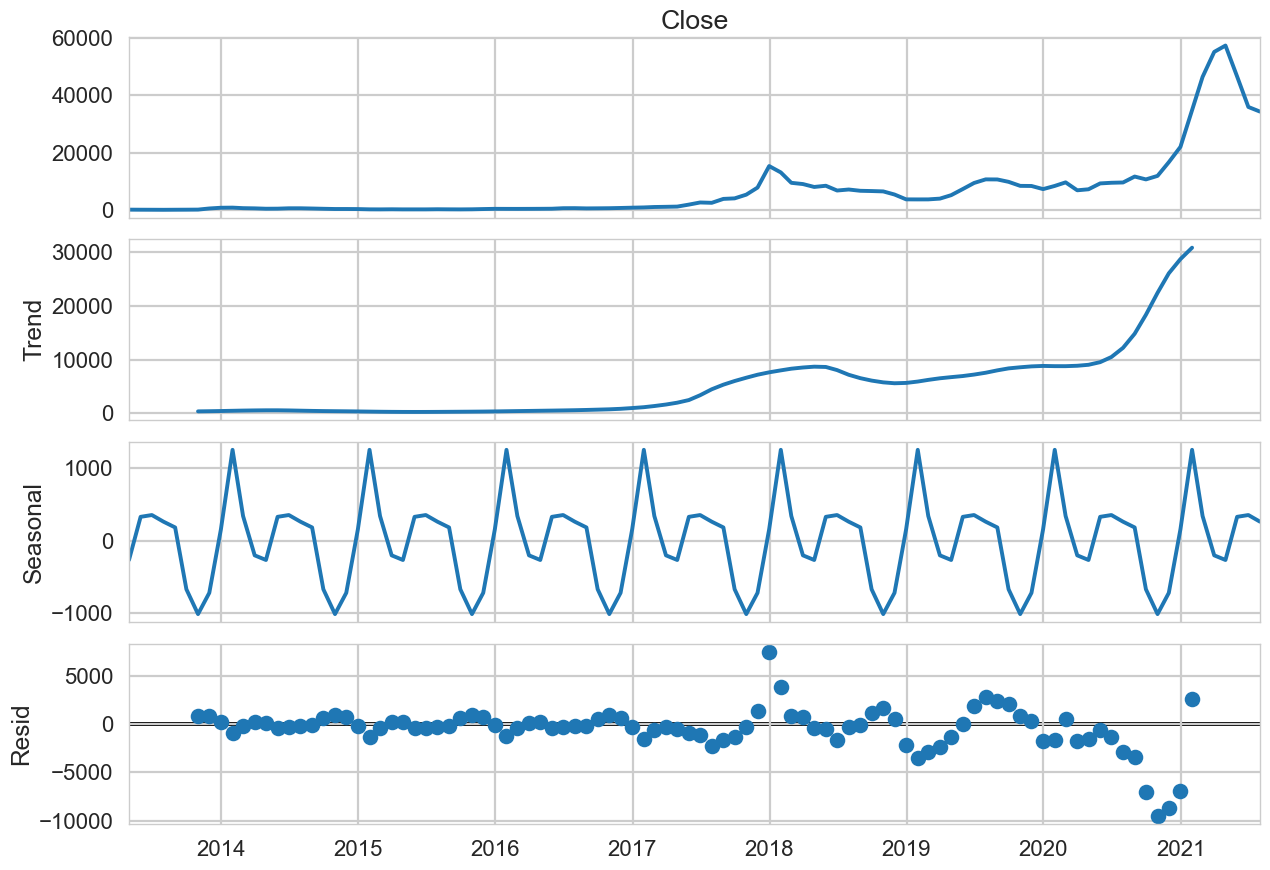

In [5]:
plt.figure(figsize=[15, 7])
sm.tsa.seasonal_decompose(df_month['Close']).plot()
print(f'Dickey–Fuller test: p={sm.tsa.stattools.adfuller(df_month["Close"])}')

In [6]:
df_month['Closed_Price_box'], lmbda = stats.boxcox(df_month['Close'])
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month['Close'])[1])
# сильно больше чем 0.05 - > ряд не стационарный

Dickey–Fuller test: p=0.999028


In [7]:
df_month['prices_box_diff'] = df_month['Closed_Price_box'] - df_month['Closed_Price_box'].shift(12) #12months
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month['prices_box_diff'][12:])[1])

Dickey–Fuller test: p=0.505127


In [8]:
df_month['prices_box_diff2'] = df_month['prices_box_diff'] - df_month['prices_box_diff'].shift(1) #

Dickey–Fuller test: (-4.621295401920429, 0.00011798543999912061, 11, 75, {'1%': -3.520713130074074, '5%': -2.9009249540740742, '10%': -2.5877813777777776}, -19.761343372569883)


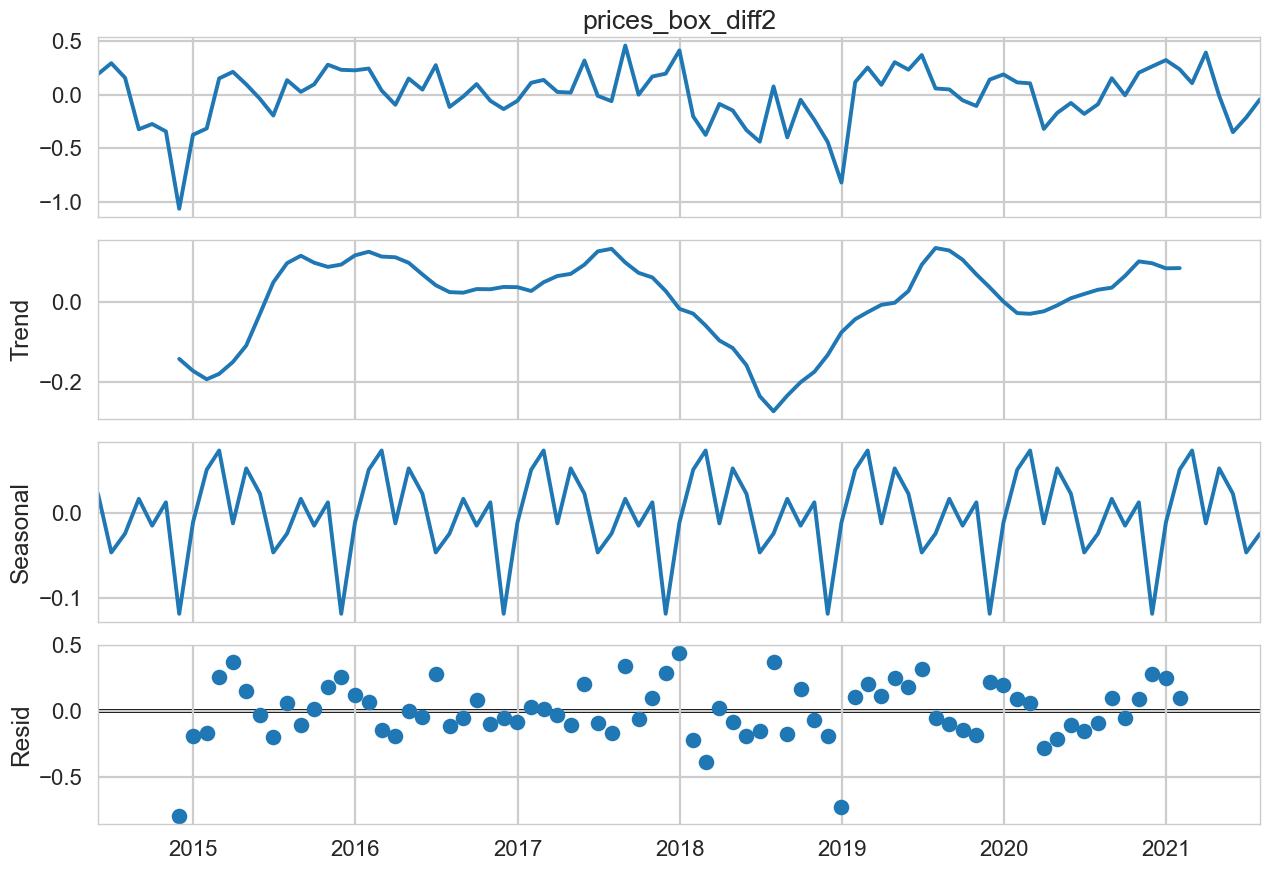

In [9]:
sm.tsa.seasonal_decompose(df_month['prices_box_diff2'][13:]).plot()
print(f"Dickey–Fuller test: {sm.tsa.stattools.adfuller(df_month['prices_box_diff2'][13:])}")

54

Dickey–Fuller test:: p=0.000000


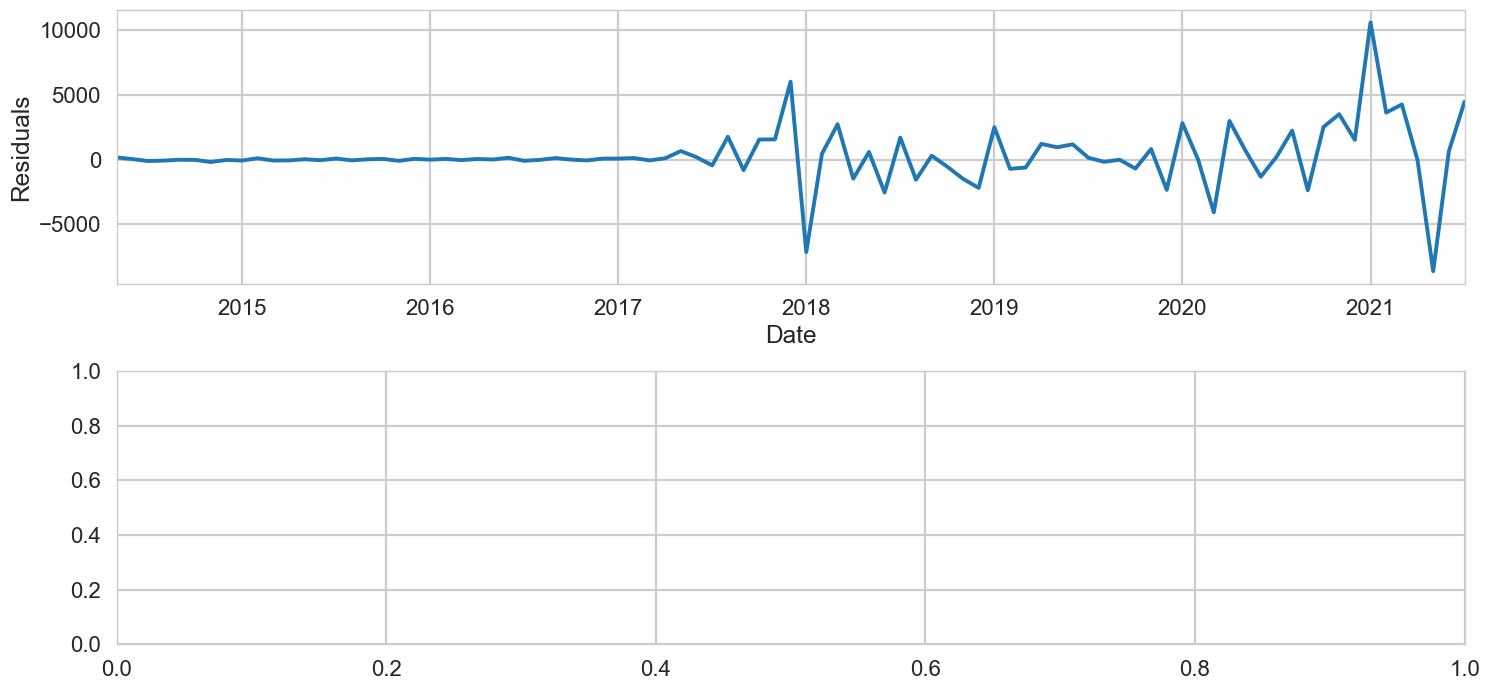

In [13]:

# STL-decomposition
plt.figure(figsize=(15, 7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
# sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()

# Экспоненциальное сглаживание

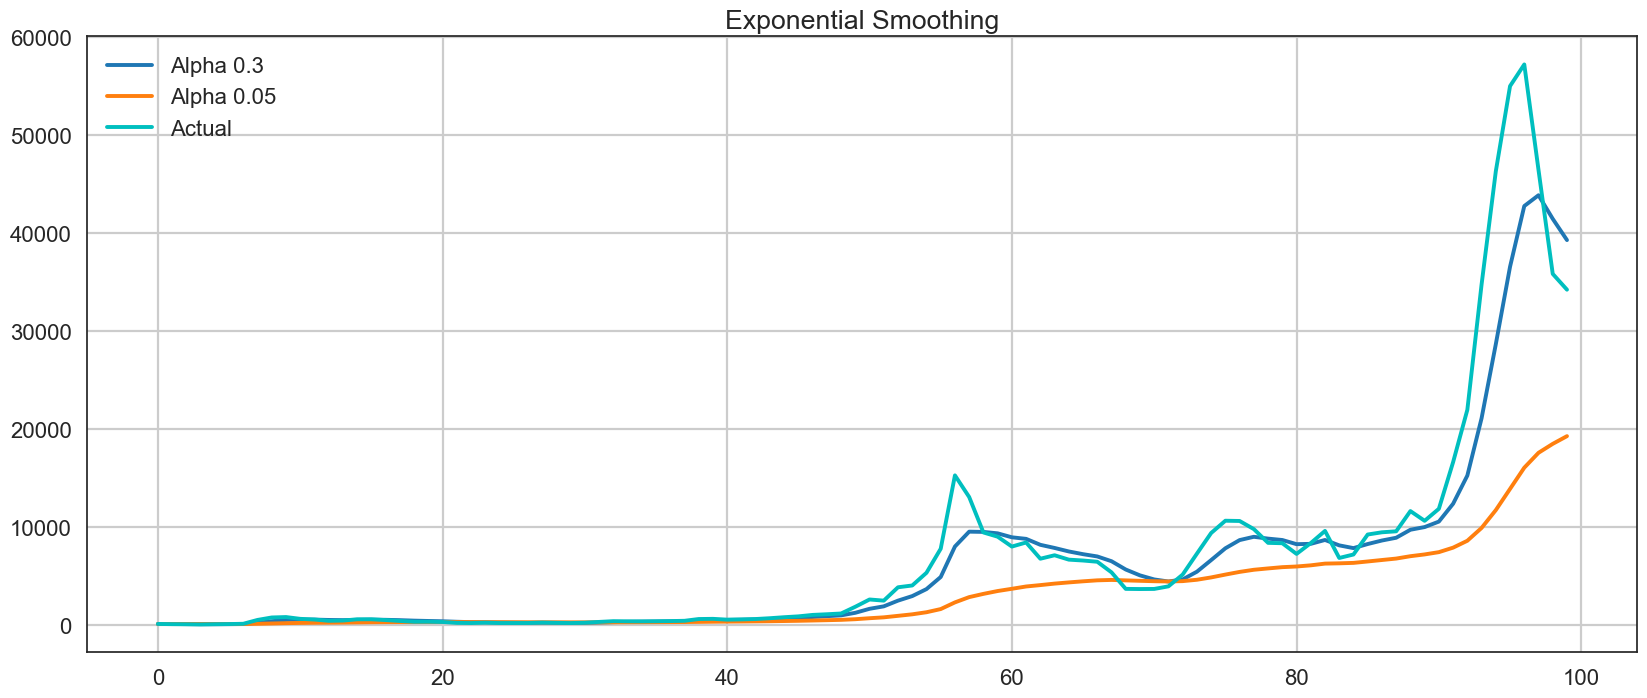

In [26]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(df_month['Close'], alpha), label="Alpha {}".format(alpha))
    plt.plot(df_month['Close'].values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

# Двойное экспоненциальное сглаживание

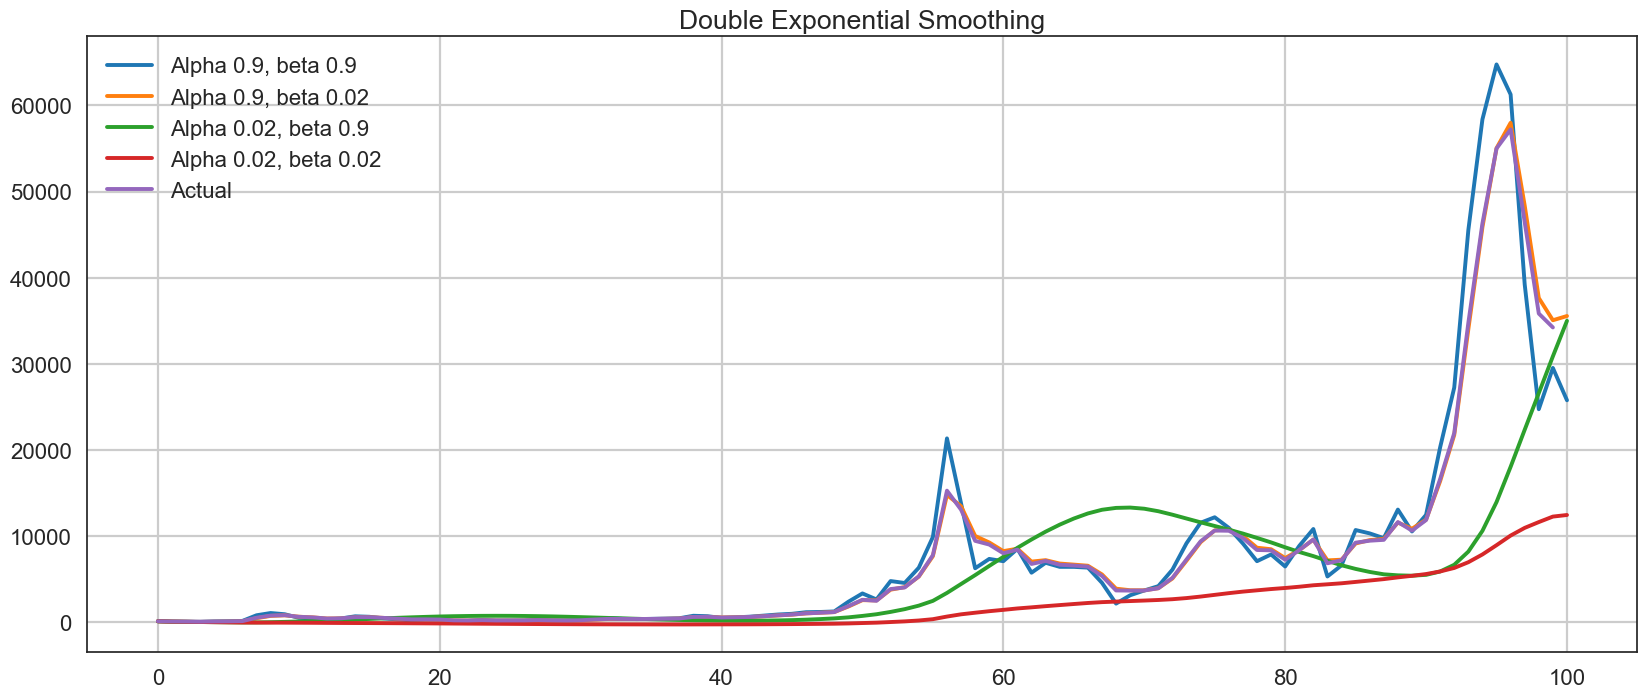

In [28]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(df_month['Close'], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(df_month['Close'].values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

# SARIMA

In [30]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [ ]:
# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        # SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) but must check if this applies to here
        model = sm.tsa.statespace.SARIMAX(df_month['Close'], order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Здесь в игру вступает информационный **критерий Акаике** (Akaike Information Criterion), который дает нам некоторую доказательную базу. Оценка по информационному критерию Акаике награждает модели, которые достигают высокого показателя критерия адекватности (с низким максимальным правдоподобием), и штрафует модели, если они становятся чрезмерно сложными (большое количество параметров k). Чем ниже, тем лучше

In [31]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())
print(best_model.summary())

      parameters          aic
43  (2, 1, 0, 1)  1607.956778
45  (2, 1, 1, 1)  1609.952040
39  (2, 0, 1, 1)  1610.094988
25  (1, 1, 0, 1)  1610.520282
49  (2, 2, 0, 1)  1610.906826
                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  100
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -798.978
Date:                            Mon, 12 Aug 2024   AIC                           1607.957
Time:                                    11:53:58   BIC                           1620.286
Sample:                                04-30-2013   HQIC                          1612.922
                                     - 07-31-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

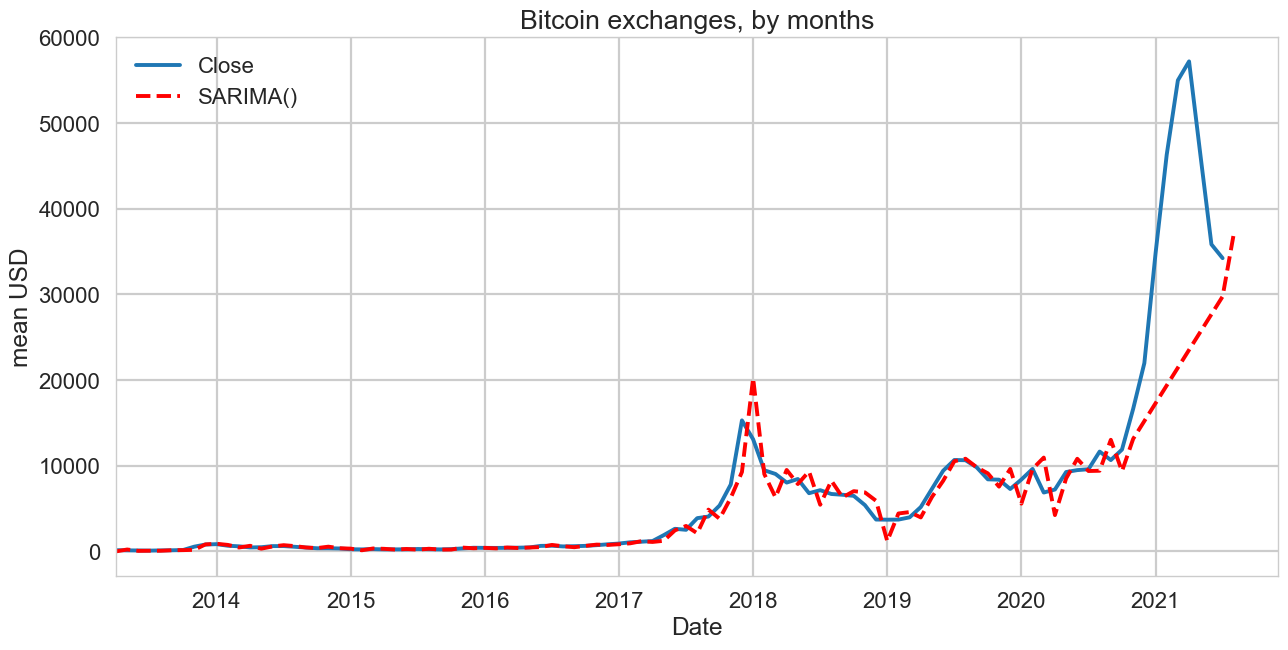

In [36]:
# Prediction
df_month2 = df_month[['Close']][:-8]
date_list = [datetime(2021, 7, 31), datetime(2021, 8, 31), datetime(2021, 9, 30),
             datetime(2021, 9, 30), datetime(2021, 10, 31), datetime(2021, 11, 30), datetime(2021, 12, 31),]

future = pd.DataFrame(index=date_list, columns=df_month2.columns)
df_month2 = pd.concat([df_month2, future])
# print(df_month2)
df_month2['forecast'] = best_model.predict(start=0, end=100)
plt.figure(figsize=(15, 7))
df_month['Close'].plot()
df_month2['forecast'].plot(color='r', ls='--', label='SARIMA()')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel(u'mean USD')
plt.show()

In [20]:
df_month2['Close']

,Close,forecast
2013-04-30,141.769997,0.000000
2013-05-31,119.992741,219.358973
2013-06-30,107.761407,59.755919
2013-07-31,90.512207,77.075689
2013-08-31,113.905484,73.848648
...,...,...
2021-09-30,NaN,40779.850604
2021-09-30,NaN,40779.850604
2021-10-31,NaN,44245.571798
2021-11-30,NaN,46828.428740


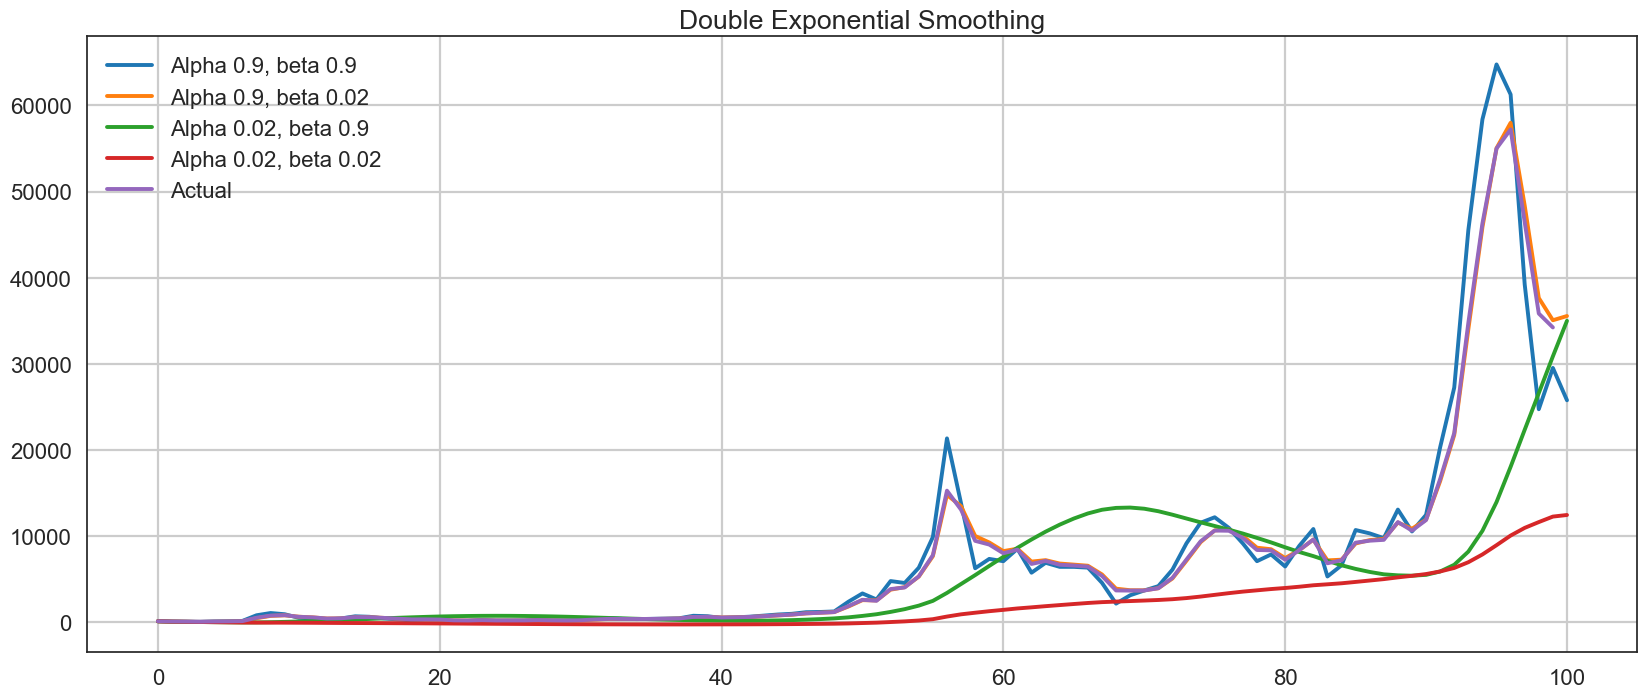

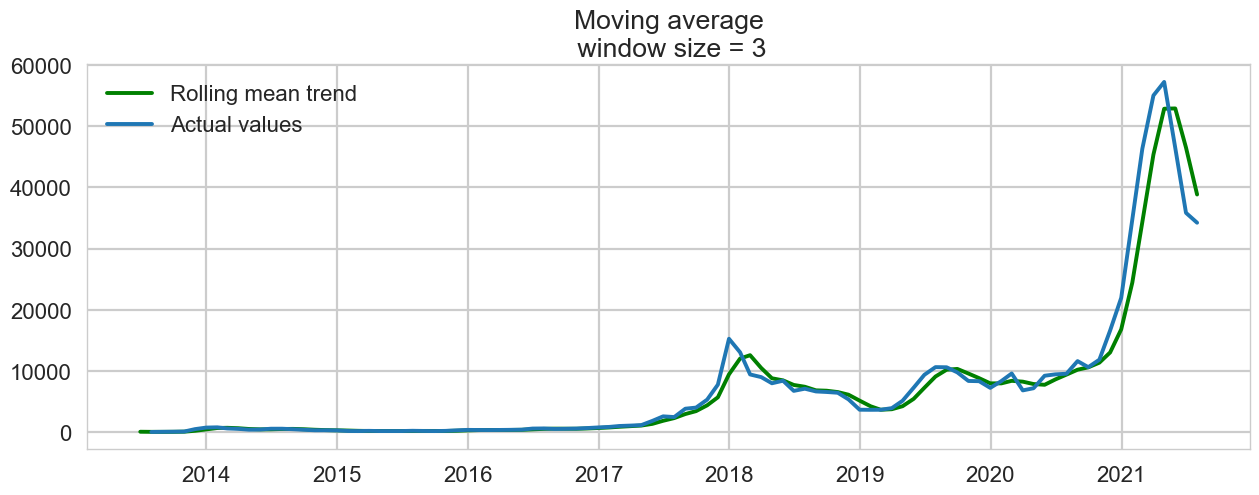

In [24]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
plotMovingAverage(df_month['Close'], 3)